___
# Model Socjo-ekonomiczny HANDY
___



## Imports

In [ ]:
!pip install SALib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 756 kB 16.3 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 46.1 MB/s 
     |████████████████████████████████| 52 kB 869 kB/s 


In [ ]:
import json
import matplotlib.pyplot as plt
import math

In [ ]:
from SALib.sample import saltelli, latin
from SALib.analyze import sobol, pawn
from SALib.test_functions import Ishigami
import numpy as np
from scipy.integrate import odeint

In [ ]:
class HandyError(Exception):
  pass

## Model

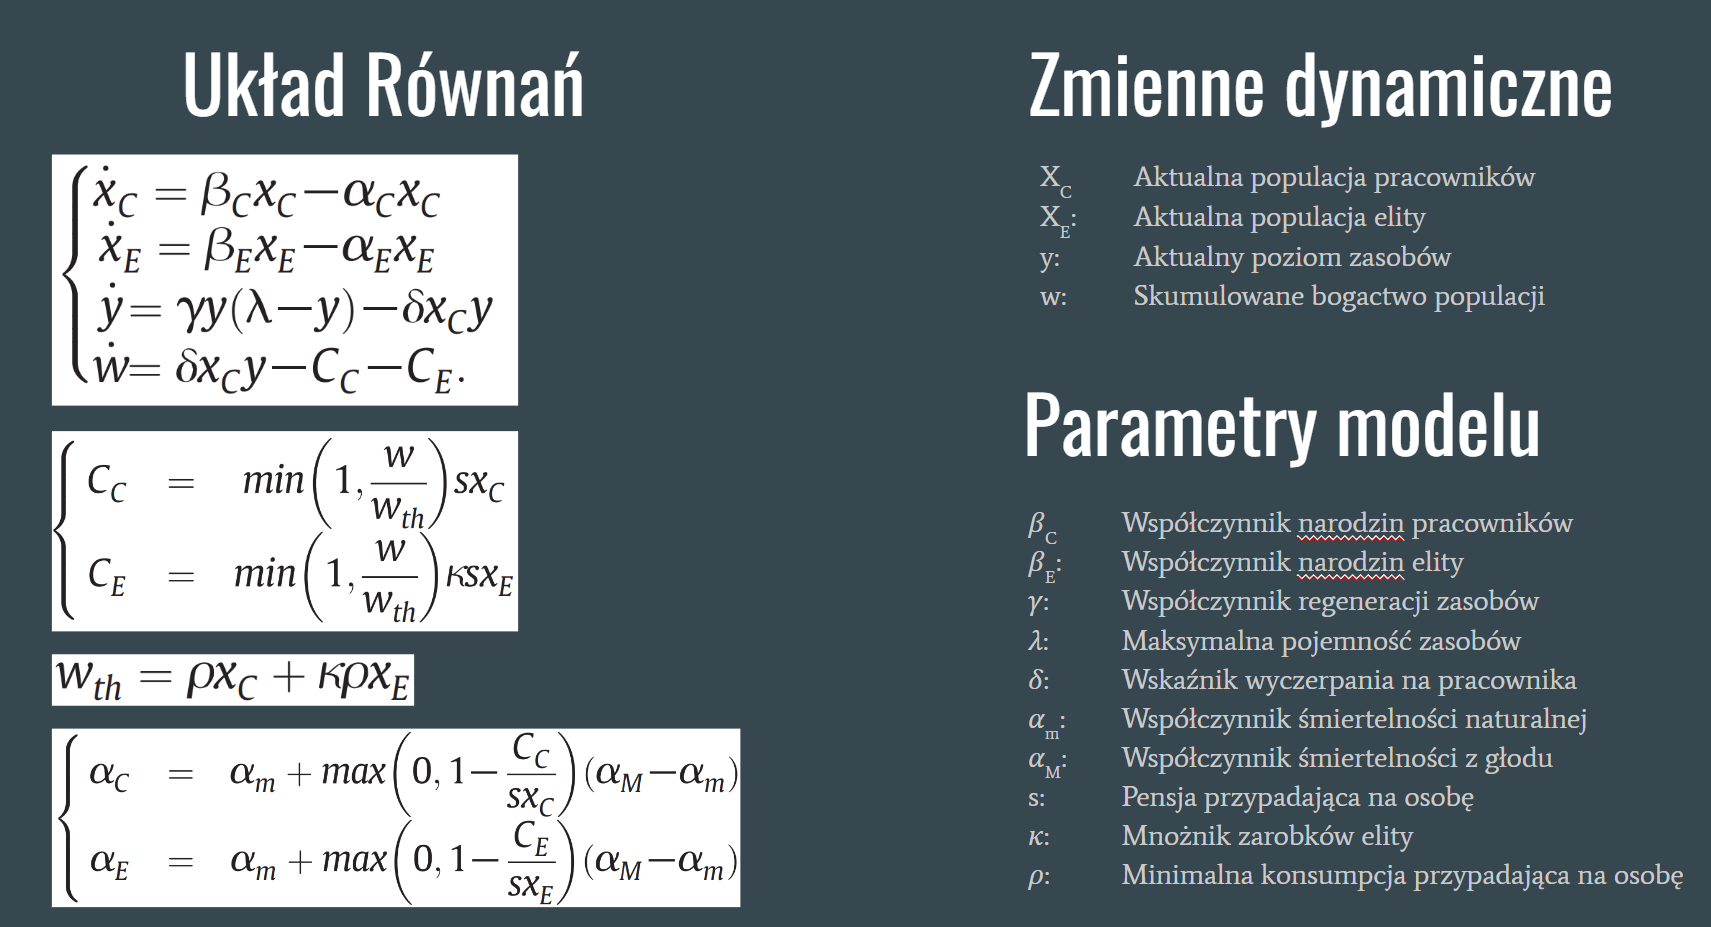

### New Model

In [ ]:
class NewHandyModel():
    def __init__(self, initialParameters: dict):
        self.data = {}
        self.initialParameters = {}
        self.initialParameters.update(initialParameters)

    def alfa(a_M, a_m, w, wth, k):
        return a_m + max(0, 1 - min(1, w/wth)*k)*(a_M - a_m)

    def model(z, t, b_c, b_e, gamma, lambd, delta, a_M, a_m, s, k, rho):
        x_c = z[0]
        x_e = z[1]
        y = z[2]
        w = z[3]
        wth = rho*(x_c + k*x_e)
        dxc_dt = (b_c - NewHandyModel.alfa(a_M, a_m, w, wth, 1)) * x_c
        dxe_dt = (b_e - NewHandyModel.alfa(a_M, a_m, w, wth, k)) * x_e
        dy_dt = gamma*y*(lambd-y) - delta*x_c*y
        dw_dt = delta*x_c*y - min(1, w/wth)*s*(x_c + x_e*k)
        
        zr = np.empty(4)
        zr[0] = dxc_dt
        zr[1] = dxe_dt
        zr[2] = dy_dt
        zr[3] = dw_dt
        for value in zr:
            if math.isnan(value) or math.isinf(value): # or value < 0.0:
                raise HandyError(f"Last values for: x_c: {x_c}, x_e: {x_e}, y: {y}, w: {w}. Time: {t}")
        return zr
    
    def evaluate(self, iterations: int = 100, plotAfter:bool = True):
        z0 = np.empty(4)
        z0[0] = self.initialParameters["x_C"]
        z0[1] = self.initialParameters["x_E"]
        z0[2] = self.initialParameters["y"]
        z0[3] = self.initialParameters["w"]

        t = np.linspace(0,iterations)

        z = odeint(NewHandyModel.model, z0, t, args=(
            self.initialParameters["beta_C"],
            self.initialParameters["beta_E"],
            self.initialParameters["gamma"],
            self.initialParameters["lambda"],
            self.initialParameters["delta"],
            self.initialParameters["alpha_M"],
            self.initialParameters["alpha_m"],
            self.initialParameters["s"],
            self.initialParameters["k"],
            self.initialParameters["rho"]))

        self.data["x_C"] = z[:,0]
        self.data["x_E"] = z[:,1]
        self.data["y"] = z[:,2]
        self.data["w"] = z[:,3]
        self.data["t"] = t.tolist()
        if plotAfter:
            self.plot()
            print(self.initialParameters)

    def plot(self, include_log_scale: bool = False):
        if include_log_scale:
            # Logarithmic scale
            fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
            fig.set_size_inches(20.0, 11.0)
            ax4.plot(self.data["t"], self.data["x_C"], label="Commoners")
            ax4.plot(self.data["t"], self.data["x_E"], label="Elite")
            ax4.set_yscale("log")
            ax4.set_title("Population")
            ax4.legend()
            ax5.plot(self.data["t"], self.data["y"], 'cyan')
            ax5.set_yscale("log")
            ax5.set_title("Available resources (y)")
            ax6.plot(self.data["t"], self.data["w"], 'green')
            ax6.set_yscale("log")
            ax6.set_title("Accumulated wealth (w)")
        else:
            fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
            fig.set_size_inches(18.0, 5.5)
        # Linear scale
        ax1.plot(self.data["t"], self.data["x_C"], label="Commoners")
        ax1.plot(self.data["t"], self.data["x_E"], label="Elite")
        ax1.set_title("Population")
        ax1.legend()
        ax2.plot(self.data["t"], self.data["y"], 'cyan')
        ax2.set_title("Available resources (y)")
        ax3.plot(self.data["t"], self.data["w"], 'green')
        ax3.set_title("Accumulated wealth (w)")

        plt.show()

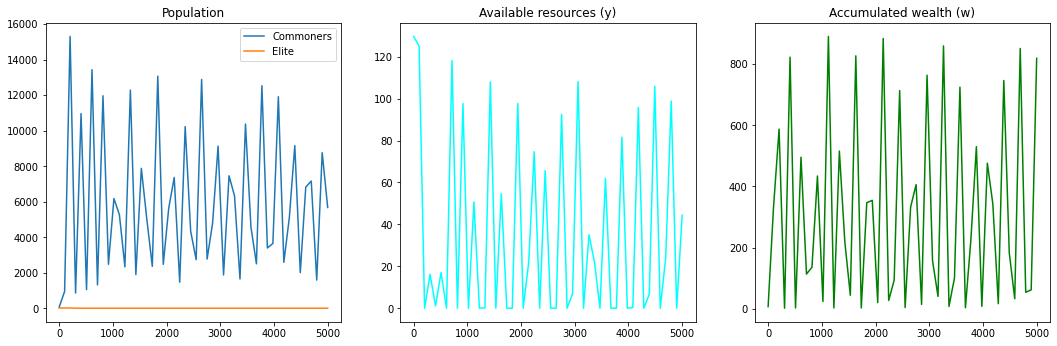

{'x_C': 57.8125, 'x_E': 12.25, 'y': 129.6875, 'w': 7.8125, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'rho': 0.040921875}


In [ ]:
values_dict = {
    'x_C': 57.8125,
    'x_E': 12.25,
    'y': 129.6875,
    'w': 7.8125,
    'beta_C': 0.0459375,
    'beta_E': 0.018437500000000002,
    'gamma': 0.00546875,
    'lambda': 142.1875,
    'delta': 0.0001034375,
    'alpha_m': 0.01859375,
    'alpha_M': 0.08421875000000001,
    's': 0.0029453125,
    'k': 5.9375,
    'rho': 0.040921875
}

model = NewHandyModel(values_dict)
model.evaluate(5000, True)

### Old Model

In [ ]:
class HANDYModel:
    def __init__(self, initialParameters: dict):

        self.values = {
            "x_C":      0, # Commoners population
            "x_E":      0, # Elites population
            "y":        0, # Available resources
            "w":        0, # Accumulated wealth

            "beta_C":   0, # Birth rate of Commoners
            "beta_E":   0, # Birth rate of Elites
            "alpha_C":  0, # Death rate of Commoners
            "alpha_E":  0, # Death rate of Elites
            "C_C":      0, # Consumption of Commoners
            "C_E":      0, # Consumption of Elites
            "gamma":    0, # Regeneration factor = How fast resources regenerate
            "lambda":   0, # Nature's capacity = How many resources can exist at one time
            "delta":    0, # Rate of depletion per worker

            "alpha_m":  0, # 'Healthy' death rate
            "alpha_M":  0, # 'Famine' death rate
            "s":        0, # Subsistence per capita
            "k":        0, # Elites salary multiplier
            "w_th":     0, # Wealth threshold, below which 'Famine' starts
            "rho":      0, # Minimum required consumption per capita
        }

        self.values.update(initialParameters)
        self.initialParameters = {}
        self.initialParameters.update(self.values)
        
        self.iterations = 0
        self.is_evaluated = False

        self.data = {
            "x_C": [],
            "x_E": [],
            "y": [],
            "w": []
        }

    def print(self):
        print("HANDY Model - Iteration " + str(self.iterations))
        print(json.dumps(self.values, sort_keys=False, indent=4))
        print("\n")

    def evaluate(self, iterations: int = 100, plotAfter:bool = True):
        for i in range(iterations):
            if self.is_evaluated: break
            self.update()
        if plotAfter:
            self.plot()
            print(self.initialParameters)
            print(self.values)

    def update(self):
        v = self.values
        v["w_th"] = v["rho"] * v["x_C"] + v["k"] * v["rho"] * v["x_E"]

        v["C_C"] = min(1, v["w"]/v["w_th"]) * v["s"] * v["x_C"]
        v["C_E"] = min(1, v["w"]/v["w_th"]) * v["k"] * v["s"] * v["x_E"]

        try:
            v["alpha_C"] = v["alpha_m"] + max(0, 1 - v["C_C"]/(v["s"] * v["x_C"])) * (v["alpha_M"] - v["alpha_m"])
        except ZeroDivisionError:
            v["alpha_C"] = v["alpha_m"]

        try:  
            v["alpha_E"] = v["alpha_m"] + max(0, 1 - v["C_E"]/(v["s"] * v["x_E"])) * (v["alpha_M"] - v["alpha_m"])
        except ZeroDivisionError:
            v["alpha_E"] = v["alpha_m"]

        v["x_C"] += v["beta_C"] * v["x_C"] - v["alpha_C"] * v["x_C"]
        v["x_E"] += v["beta_E"] * v["x_E"] - v["alpha_E"] * v["x_E"]

        v["y"] += v["gamma"] * v["y"] * (v["lambda"] - v["y"]) - v["delta"] * v["x_C"] * v["y"]
        v["w"] += v["delta"] * v["x_C"] * v["y"] - v["C_C"] - v["C_E"]

        for var_name in ["x_C", "x_E", "y", "w"]:
            if math.isnan(v[var_name]) or math.isinf(v[var_name]) or v[var_name] < 0.0:
                raise HandyError(var_name + "_last = " + str(self.data[var_name][-1]))
            self.data[var_name].append(v[var_name])

        self.iterations += 1

    def plot(self, oldVersion=False):
        if oldVersion:
            fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
            fig.set_size_inches(18.5, 5.5)
            ax1.plot(self.data["x_C"], label="Commoners")
            ax1.plot(self.data["x_E"], label="Elite")
            ax1.set_title("Population")
            ax1.legend()
            ax2.plot(self.data["y"], 'cyan')
            ax2.set_title("Available resources (y)")
            ax3.plot(self.data["w"], 'green')
            ax3.set_title("Accumulated wealth (w)")
            plt.show()

        else:
            fig = plt.figure(figsize=(16,9))

            grid = plt.GridSpec(3, 3, hspace=0.25)
            ax1 = fig.add_subplot(grid[0, :])
            ax2 = fig.add_subplot(grid[1, :])
            ax3 = fig.add_subplot(grid[2, :])
            
            ax1.plot(self.data["x_C"], label="Commoners")
            ax1.plot(self.data["x_E"], label="Elite")
            ax1.set_title("Population")
            ax1.grid(axis = 'x')
            ax1.legend()

            ax2.plot(self.data["y"], 'cyan')
            ax2.set_title("Available resources (y)")
            ax2.grid(axis = 'x')

            ax3.plot(self.data["w"], 'green')
            ax3.set_title("Accumulated wealth (w)")
            ax3.grid(axis = 'x')

            v = self.values

            main_title = f"""Parameters: 
            \n{r'$β_C$'} = {'{:.3e}'.format(v['beta_C'])}
            \n{r'$β_E$'} = {'{:.3e}'.format(v['beta_E'])}
            \n{r'$γ$'} = {'{:.3e}'.format(v['gamma'])}
            \n{r'$λ$'} = {'{:.3e}'.format(v['lambda'])}
            \n{r'$δ$'} = {'{:.3e}'.format(v['delta'])}
            \n{r'$α_m$'} = {'{:.3e}'.format(v['alpha_m'])}
            \n{r'$α_M$'} = {'{:.3e}'.format(v['alpha_M'])}
            \n{r'$s$'} = {'{:.3e}'.format(v['s'])}
            \n{r'$k$'} = {'{:.3e}'.format(v['k'])}
            \n{r'$ρ$'} = {'{:.3e}'.format(v['rho'])}
            """
            
            #fig.tight_layout()
            fig.subplots_adjust(left=0.23)
            fig.patch.set_alpha(0.9)
            fig.suptitle(main_title, fontsize=16, horizontalalignment='right', verticalalignment='center', x=0.19, y=0.5)

            plt.show()

    

    def plotAllOnOne(self):
        fig, ((ax1)) = plt.subplots(1, 1)
        fig.set_size_inches(18.5, 5.5)
        ax1.plot(self.data["x_C"], label="x_C")
        ax1.plot(self.data["x_E"], label="x_E")
        
        ax2 = ax1.twinx()
        ax2.plot(self.data["y"])
        ax2.plot(self.data["w"])
        plt.legend()
        
        plt.show()

## Generation of testing plots

In [ ]:
# TODO: musimy ręcznie się pobawić i spróbować ograniczyć zakres inputu, żeby biblioteka to uciągnęła

num_vars = 14
keys_map = ['x_C', 'x_E', 'y', 'w', 'beta_C', 'beta_E', 'gamma', 'lambda', 'delta', 'alpha_m', 'alpha_M', 's', 'k', 'rho']

# EXAMPLE: https://salib.readthedocs.io/en/latest/basics.html#what-is-sensitivity-analysis

# Kosztyla_SALib_problem = {
#     'num_vars': num_vars,
#     'names': keys_map,
#     'bounds': [[1, 100],         # Commoners population
#                [1, 25],         # Elites population
#                [50, 150],       # Available resources
#                [0, 10],         # Accumulated wealth
#                [0.0015, 0.06],      # Birth rate of Commoners
#                [0.0015, 0.06],      # Birth rate of Elites
#                [0.005, 0.02],      # Regeneration factor = How fast resources regenerate
#                [50, 150],       # Nature's capacity = How many resources can exist at one time
#                [0.00001, 0.003],  # Rate of depletion per worker
#                [0.005, 0.02],      # 'Healthy' death rate
#                [0.035, 0.14],      # 'Famine' death rate
#                [0.00025, 0.004],    # Subsistence per capita
#                [1, 20],           # Elites salary multiplier
#                [0.005, 0.02]]      # Minimum required consumption per capita
# }

SALib_problem = {
    'num_vars': num_vars,
    'names': keys_map,
    'bounds': [[50, 150],         # Commoners population
               [1, 25],         # Elites population
               [50, 150],       # Available resources
               [0, 10],         # Accumulated wealth
               [0.01, 0.06],      # Birth rate of Commoners
               [0.01, 0.06],      # Birth rate of Elites
               [0.004, 0.006],      # Regeneration factor = How fast resources regenerate
               [50, 150],       # Nature's capacity = How many resources can exist at one time
               [0.00001, 0.003],  # Rate of depletion per worker
               [0.005, 0.02],      # 'Healthy' death rate
               [0.035, 0.14],      # 'Famine' death rate
               [0.00025, 0.004],    # Subsistence per capita
               [2, 12],           # Elites salary multiplier
               [0.005, 0.04]]      # Minimum required consumption per capita
}

In [ ]:
param_values = saltelli.sample(SALib_problem, 32)

In [ ]:
from tqdm import tqdm
X_C = np.zeros([param_values.shape[0]])
X_E = np.zeros([param_values.shape[0]])
Y = np.zeros([param_values.shape[0]])
W = np.zeros([param_values.shape[0]])

skipped = 0
for i, X in tqdm(iterable=enumerate(param_values), total=param_values.shape[0]):
    initialParameters = {}
    for j in range(num_vars):
        initialParameters[keys_map[j]] = X[j]
    model = NewHandyModel(initialParameters)
    try:
        model.evaluate(1500, plotAfter=True)
        X_C[i] = model.data['x_C'][-1]
        X_E[i] = model.data['x_E'][-1]
        Y[i] = model.data['y'][-1]
        W[i] = model.data['w'][-1]

    except HandyError as e:
        skipped += 1
        
print(f"All evaluations ended, skipped: {skipped}")

## SA

#### SOBOL

               ST       ST_conf
x_C      0.009730  2.467199e+02
x_E      0.000191  6.989802e+00
y        0.000346  2.563018e+00
w        0.000050  3.979415e+00
beta_C   1.015979  2.306280e+04
beta_E   0.000989  4.618783e-01
gamma    0.155286  3.284621e+00
lambda   0.385825  4.361721e-01
delta    0.004453  1.027856e+01
alpha_m  0.078098  2.920769e-01
alpha_M  6.604012  9.348805e+15
s        0.235253  2.221715e+03
k        0.000300  1.532575e+03
rho      0.013301  1.977991e-01
               S1       S1_conf
x_C     -0.003401  6.754097e+08
x_E     -0.000477  9.305685e+07
y       -0.000641  4.702219e+07
w        0.000244  9.484919e+07
beta_C   0.034748  7.890954e+09
beta_E  -0.001084  2.400639e+06
gamma   -0.013585  5.666617e+07
lambda   0.021414  1.920409e+07
delta   -0.002301  1.176059e+08
alpha_m  0.009634  1.097644e+07
alpha_M -0.046806  1.363985e+14
s        0.016721  2.025490e+09
k        0.000597  1.731338e+09
rho     -0.003976  1.922648e+07
                      S2       S2_conf
(

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e58fa110>,
      dtype=object)

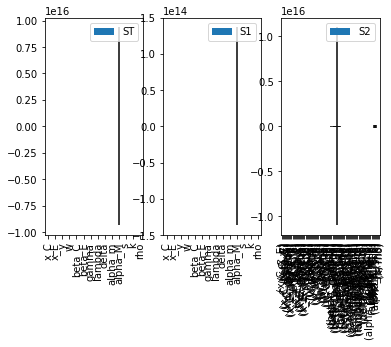

In [ ]:
Si_X_C = sobol.analyze(SALib_problem, X_C, print_to_console=True)
Si_X_C.plot()

                   ST       ST_conf
x_C      1.916426e-23      1.266568
x_E      3.259467e-23      0.587069
y        3.240058e-23      0.586908
w        3.612255e-23      2.332546
beta_C   3.123037e-23      0.565623
beta_E   6.695517e-18     91.050491
gamma    3.417278e-23      1.213772
lambda   5.334932e-22    305.308174
delta    3.792684e-23      1.709162
alpha_m  8.961215e-23      1.608781
alpha_M  3.849762e+00  73901.175339
s        3.647531e-23      1.018638
k        3.596036e-23      0.870114
rho      3.240077e-23      0.586908
                   S1       S1_conf
x_C     -2.758291e-13  4.324057e+10
x_E      3.035569e-13  5.878134e+09
y        2.822494e-13  5.112894e+09
w        1.865878e-13  5.905056e+10
beta_C   2.967946e-13  6.133371e+09
beta_E  -1.280527e-10  1.383922e+10
gamma    2.157001e-13  4.113731e+10
lambda  -7.432012e-13  6.783554e+11
delta    2.728483e-13  5.131098e+10
alpha_m -3.898242e-13  1.346293e+10
alpha_M  3.857891e+00  8.088789e+12
s        3.050365e-13  3.455

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e5702550>,
      dtype=object)

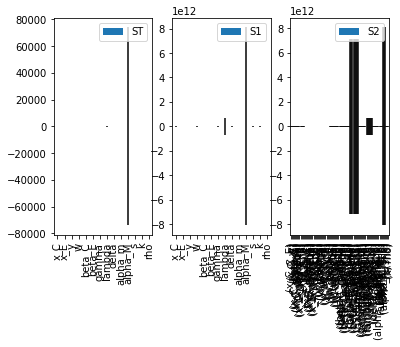

In [ ]:
Si_X_E = sobol.analyze(SALib_problem, X_E, print_to_console=True)
Si_X_E.plot()

                   ST       ST_conf
x_C      4.590046e-01  3.870970e-01
x_E      4.673302e-01  3.084264e-01
y        3.076474e-01  2.793223e-01
w        4.480057e-01  3.613092e-01
beta_C   5.585795e+00  3.189632e+00
beta_E   6.177141e-01  2.971312e-01
gamma    1.000349e+00  1.268686e+00
lambda   6.392874e-01  3.745692e-01
delta    4.776443e+18  9.315634e+18
alpha_m  2.379225e-01  2.273759e-01
alpha_M  4.626669e-01  3.477268e-01
s        3.017577e-01  2.533518e-01
k        4.339797e-01  3.772914e-01
rho      4.001988e-01  2.943215e-01
                   S1       S1_conf
x_C      7.137214e+05  6.094007e+06
x_E     -4.065923e+06  4.861301e+06
y       -5.867853e+06  4.729373e+06
w       -1.976437e+06  5.632734e+06
beta_C   4.206121e+07  2.059174e+07
beta_E  -4.744667e+06  6.058738e+06
gamma    1.930003e+06  9.187624e+06
lambda   8.947175e+05  6.628903e+06
delta   -9.951984e+15  1.940964e+16
alpha_m  6.204968e+05  4.819454e+06
alpha_M -4.439688e+06  5.997227e+06
s       -4.257252e+06  4.346

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e50f2ed0>,
      dtype=object)

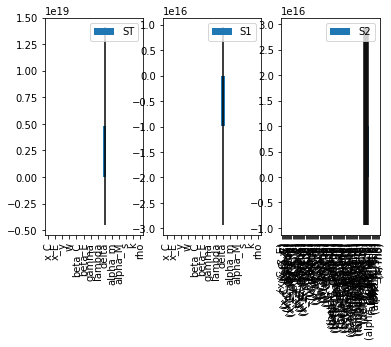

In [ ]:
Si_Y = sobol.analyze(SALib_problem, Y, print_to_console=True)
Si_Y.plot()

               ST       ST_conf
x_C      0.009683  1.732371e+11
x_E      0.016369  5.546648e-01
y        0.001157  2.821603e-01
w        0.002421  3.770682e+10
beta_C   0.180842  1.346076e+12
beta_E   0.022735  8.860177e-01
gamma    0.289806  5.111347e+08
lambda   0.018422  8.654761e+04
delta    0.023370  2.635037e+00
alpha_m  0.228472  7.145113e+00
alpha_M  0.000749  1.823362e-01
s        0.021732  2.395511e+09
k        0.024028  7.108846e+10
rho      0.001156  2.821600e-01
               S1       S1_conf
x_C     -0.005617  9.374066e+10
x_E     -0.003747  4.320217e+01
y        0.001479  5.452135e-01
w       -0.000060  4.446754e+10
beta_C  -0.023240  3.234951e+11
beta_E   0.006048  2.429345e+03
gamma   -0.021280  5.179743e+09
lambda   0.006921  9.320896e+07
delta    0.010828  5.087943e+05
alpha_m -0.019465  2.725513e+02
alpha_M  0.001064  3.480249e+00
s        0.007045  1.109419e+10
k        0.005381  6.105298e+10
rho      0.001415  6.140931e+01
                      S2       S2_conf
(

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e5159410>,
      dtype=object)

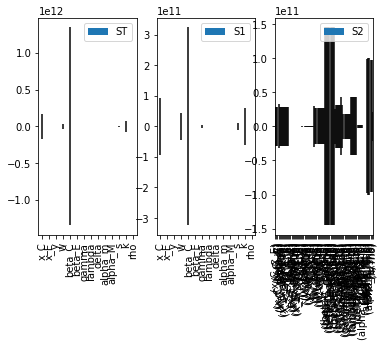

In [ ]:
Si_W = sobol.analyze(SALib_problem, W, print_to_console=True)
Si_W.plot()

#### PAWN

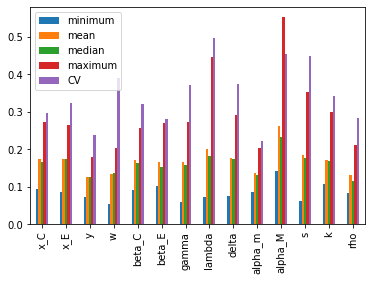

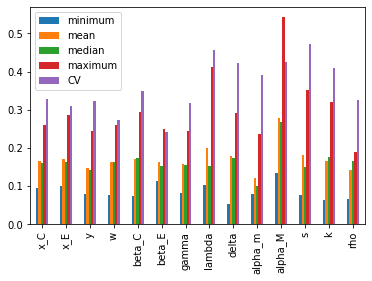

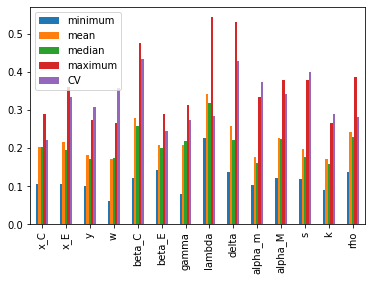

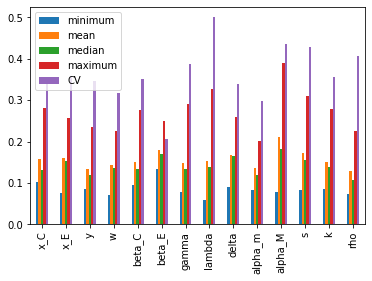

In [ ]:
Si_X_C = pawn.analyze(SALib_problem, param_values, X_C)
Si_X_C.plot()
Si_X_E = pawn.analyze(SALib_problem, param_values, X_E)
Si_X_E.plot()
Si_Y = pawn.analyze(SALib_problem, param_values, Y)
Si_Y.plot()
Si_W = pawn.analyze(SALib_problem, param_values, W)
Si_W.plot()

## Baseline propositions

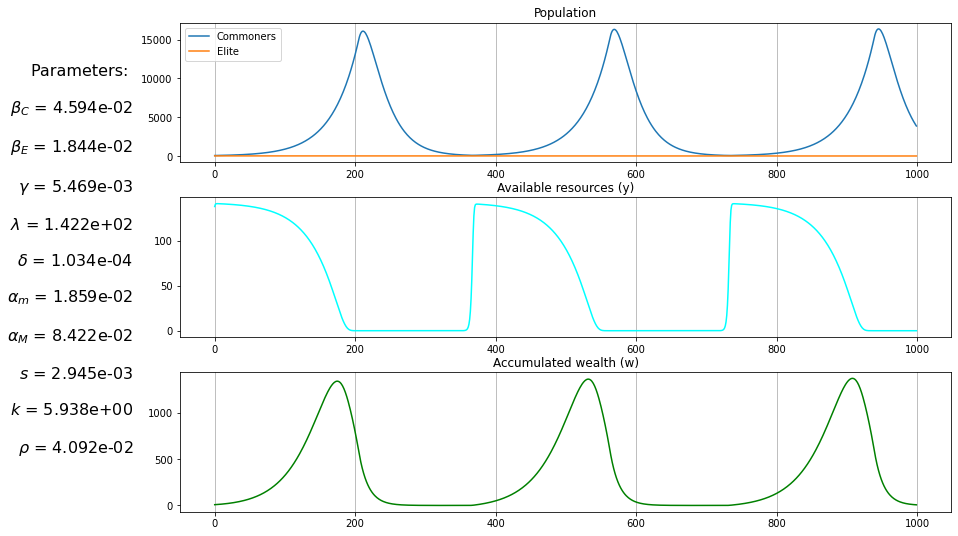

{'x_C': 57.8125, 'x_E': 12.25, 'y': 129.6875, 'w': 7.8125, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 0, 'rho': 0.040921875}
{'x_C': 3867.639210685459, 'x_E': 1.2533427971198864e-06, 'y': 6.85970019469235e-24, 'w': 6.733593796928506, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0.08131665740390384, 'alpha_E': 0.06698757521067894, 'C_C': 0.5222309929006336, 'C_E': 1.0187341982115796e-09, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 164.07591630257235, 'rho': 0.040921875}


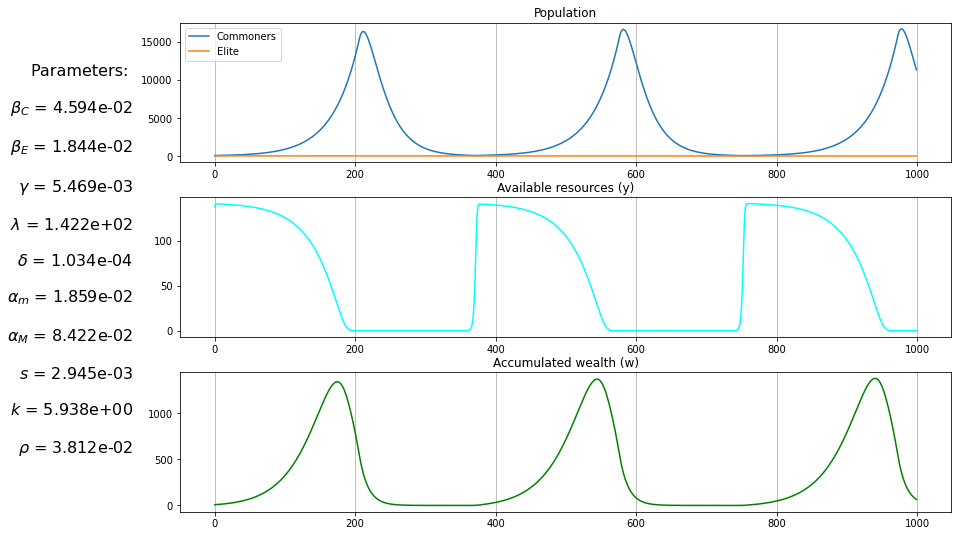

{'x_C': 57.8125, 'x_E': 12.25, 'y': 129.6875, 'w': 7.8125, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 0, 'rho': 0.038125}
{'x_C': 11309.623104412241, 'x_E': 8.235319465177679e-07, 'y': 1.533098412593934e-26, 'w': 64.89153557279923, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0.0738138292645732, 'alpha_E': 0.022439533133403286, 'C_C': 5.432846746751449, 'C_E': 2.292590360396171e-09, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 443.54375273207245, 'rho': 0.038125}


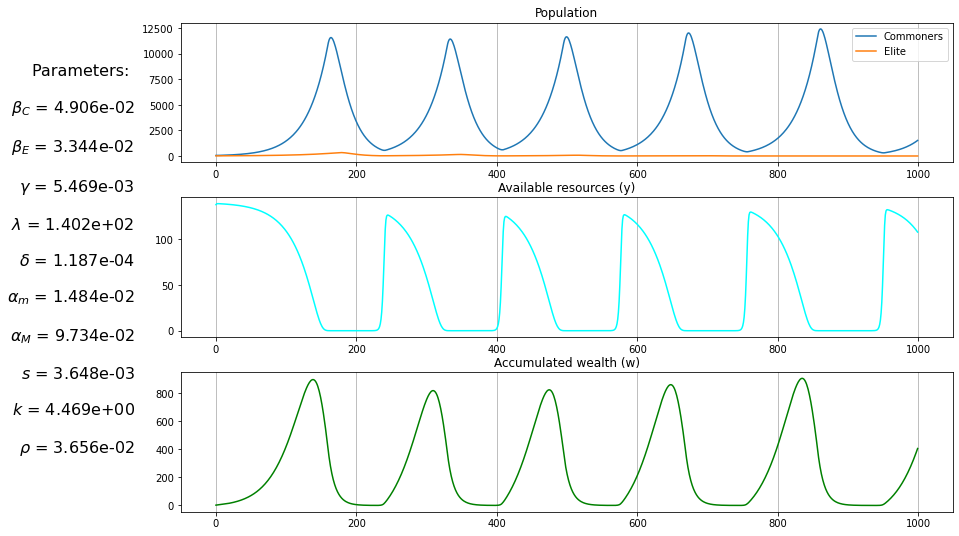

{'x_C': 55.9375, 'x_E': 12.96875, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005}
{'x_C': 1523.0913234055045, 'x_E': 0.8738352102188628, 'y': 107.80086221845869, 'w': 404.97392855751855, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0.01484375, 'alpha_E': 0.01484375, 'C_C': 5.37304462932747, 'C_E': 0.01398690107129781, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 53.985669298214646, 'rho': 0.036562500000000005}


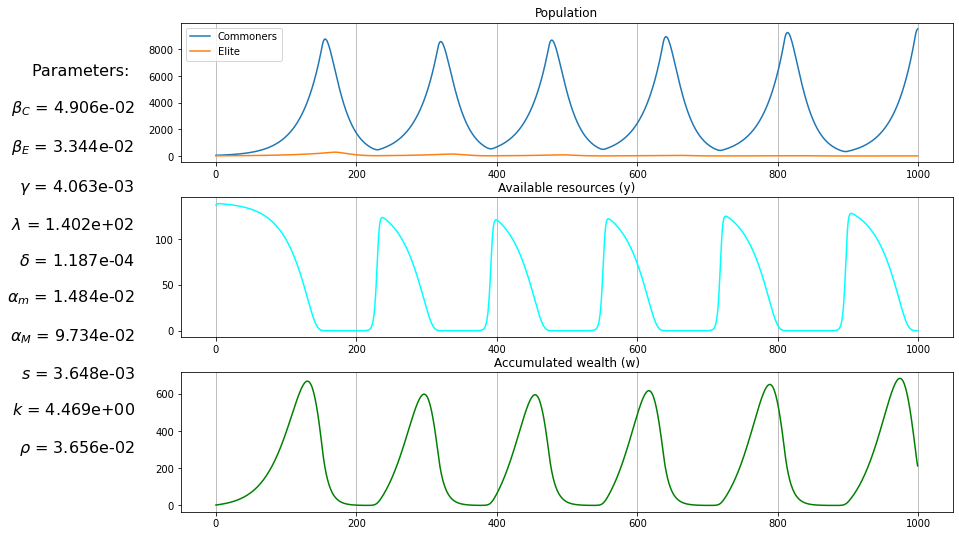

{'x_C': 55.9375, 'x_E': 12.96875, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0040625, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005}
{'x_C': 9520.969790445795, 'x_E': 8.358034663751292, 'y': 0.0037834894811307855, 'w': 212.3985230600686, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0.04120665168932805, 'alpha_E': 0.01484375, 'C_C': 23.4523134335111, 'C_E': 0.09103159304800951, 'gamma': 0.0040625, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 346.7377508827168, 'rho': 0.036562500000000005}


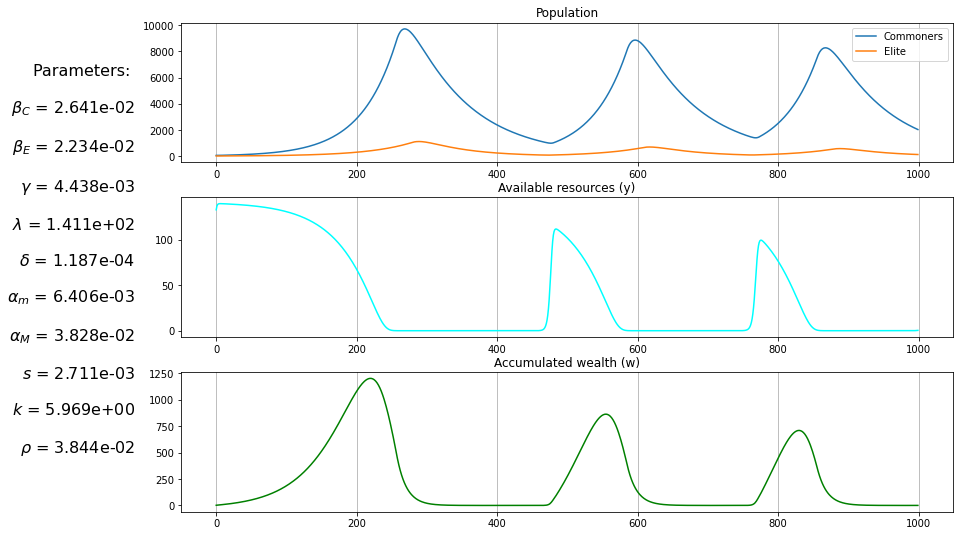

{'x_C': 58.4375, 'x_E': 12.53125, 'y': 124.21875, 'w': 0.9375, 'beta_C': 0.02640625, 'beta_E': 0.022343750000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00011875, 'alpha_m': 0.0064062500000000005, 'alpha_M': 0.03828125, 's': 0.0027109375, 'k': 5.96875, 'w_th': 0, 'rho': 0.0384375}
{'x_C': 2033.1354134686042, 'x_E': 125.17103059198452, 'y': 0.37855085566989577, 'w': 0.29818945663846685, 'beta_C': 0.02640625, 'beta_E': 0.022343750000000002, 'alpha_C': 0.038215739466115055, 'alpha_E': 0.03789023400087424, 'C_C': 0.011463205456949736, 'C_E': 0.004228364840962299, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00011875, 'alpha_m': 0.0064062500000000005, 'alpha_M': 0.03828125, 's': 0.0027109375, 'k': 5.96875, 'w_th': 108.2532863264612, 'rho': 0.0384375}


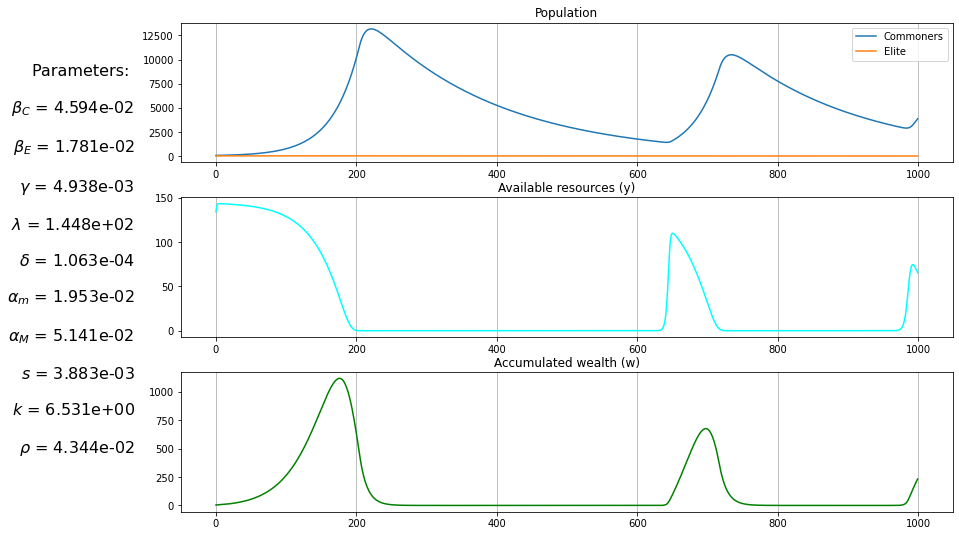

{'x_C': 56.5625, 'x_E': 12.65625, 'y': 120.46875, 'w': 3.4375, 'beta_C': 0.0459375, 'beta_E': 0.0178125, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0049375, 'lambda': 144.84375, 'delta': 0.00010625000000000001, 'alpha_m': 0.01953125, 'alpha_M': 0.05140625, 's': 0.0038828125, 'k': 6.53125, 'w_th': 0, 'rho': 0.0434375}
{'x_C': 3854.58727764304, 'x_E': 2.21463734513624e-09, 'y': 65.57643947310704, 'w': 232.30854015062118, 'beta_C': 0.0459375, 'beta_E': 0.0178125, 'alpha_C': 0.01953125, 'alpha_E': 0.01953125, 'C_C': 14.581594435900373, 'C_E': 5.6259054857796775e-11, 'gamma': 0.0049375, 'lambda': 144.84375, 'delta': 0.00010625000000000001, 'alpha_m': 0.01953125, 'alpha_M': 0.05140625, 's': 0.0038828125, 'k': 6.53125, 'w_th': 163.12608664772407, 'rho': 0.0434375}


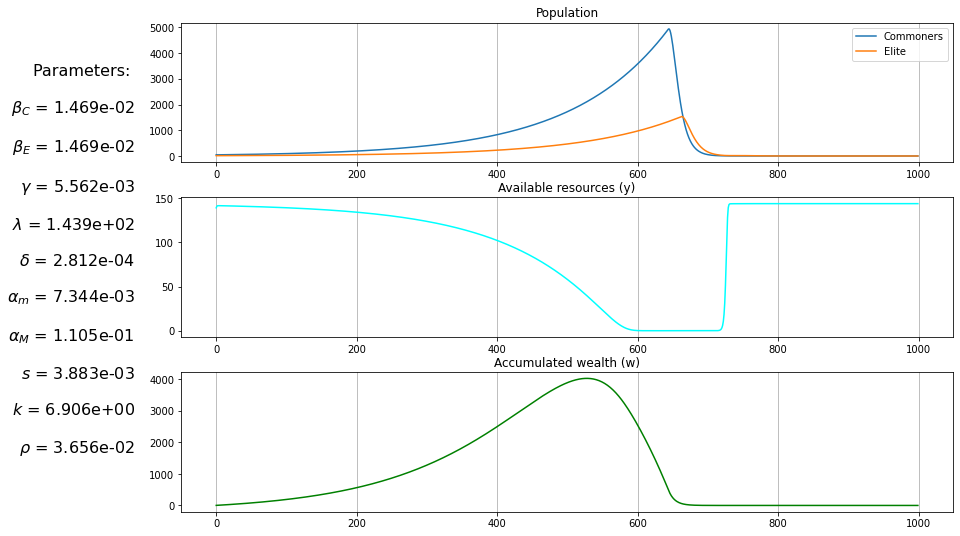

{'x_C': 52.8125, 'x_E': 12.71875, 'y': 132.65625, 'w': 0.3125, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 0, 'rho': 0.036562500000000005}
{'x_C': 1.3281209410067766e-11, 'x_E': 2.054216049743672e-08, 'y': 143.90624999999932, 'w': 4.0541790967397726e-11, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0.10965925658874244, 'alpha_E': 0.10487818612850243, 'C_C': 4.472715429683114e-16, 'C_E': 4.752627873255279e-12, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 5.701836871809535e-09, 'rho': 0.036562500000000005}


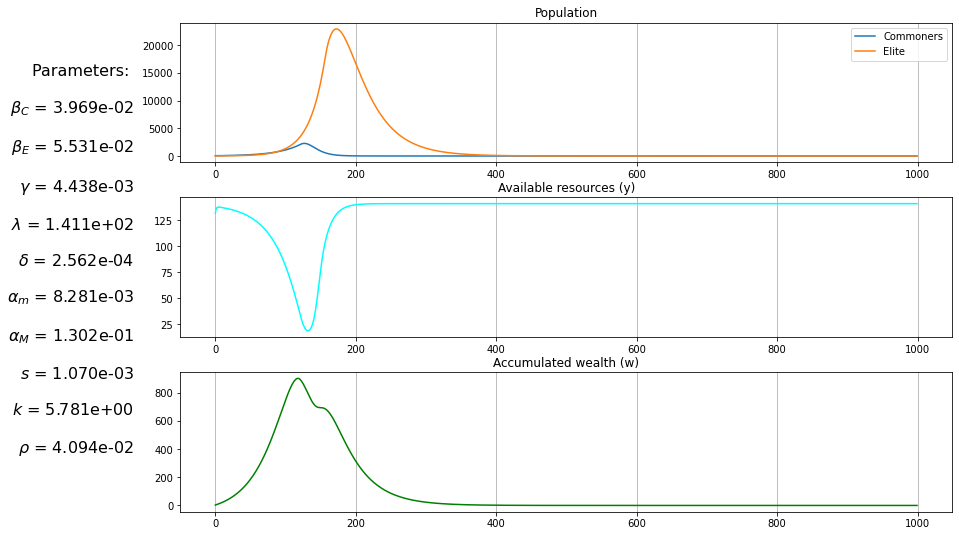

{'x_C': 57.8125, 'x_E': 12.90625, 'y': 124.21875, 'w': 0.9375, 'beta_C': 0.0396875, 'beta_E': 0.0553125, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00025624999999999997, 'alpha_m': 0.00828125, 'alpha_M': 0.13015625000000003, 's': 0.0010703125, 'k': 5.78125, 'w_th': 0, 'rho': 0.0409375}
{'x_C': 3.417526177956072e-29, 'x_E': 1.2675989992348846e-05, 'y': 141.09375, 'w': 2.073509596945558e-07, 'beta_C': 0.0396875, 'beta_E': 0.0553125, 'alpha_C': 0.12173268903445433, 'alpha_E': 0.08145753816793894, 'C_C': 2.7541160733872907e-33, 'C_E': 5.5667414223308124e-09, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00025624999999999997, 'alpha_m': 0.00828125, 'alpha_M': 0.13015625000000003, 's': 0.0010703125, 'k': 5.78125, 'w_th': 3.0805671057358444e-06, 'rho': 0.0409375}


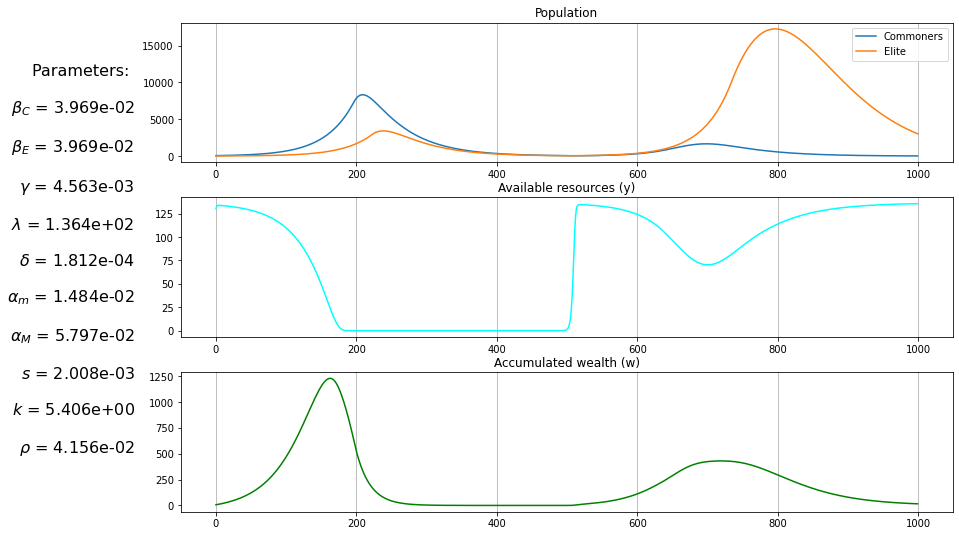

{'x_C': 57.8125, 'x_E': 12.21875, 'y': 125.15625, 'w': 5.3125, 'beta_C': 0.0396875, 'beta_E': 0.0396875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.004562500000000001, 'lambda': 136.40625, 'delta': 0.00018125, 'alpha_m': 0.01484375, 'alpha_M': 0.057968750000000006, 's': 0.0020078125, 'k': 5.40625, 'w_th': 0, 'rho': 0.0415625}
{'x_C': 20.33491783930524, 'x_E': 3025.682380487416, 'y': 135.58956582924247, 'w': 15.649663868980882, 'beta_C': 0.0396875, 'beta_E': 0.0396875, 'alpha_C': 0.05697324937016669, 'alpha_E': 0.05258682471996366, 'C_C': 0.0009590709860141282, 'C_E': 0.7680572566741746, 'gamma': 0.004562500000000001, 'lambda': 136.40625, 'delta': 0.00018125, 'alpha_m': 0.01484375, 'alpha_M': 0.057968750000000006, 's': 0.0020078125, 'k': 5.40625, 'w_th': 689.6069642133444, 'rho': 0.0415625}


In [ ]:
# Baseline candidates:
baseline_cadidates_list = [
    {'x_C': 57.8125, 'x_E': 12.25, 'y': 129.6875, 'w': 7.8125, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 0, 'rho': 0.040921875},
    {'x_C': 57.8125, 'x_E': 12.25, 'y': 129.6875, 'w': 7.8125, 'beta_C': 0.0459375, 'beta_E': 0.018437500000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 142.1875, 'delta': 0.0001034375, 'alpha_m': 0.01859375, 'alpha_M': 0.08421875000000001, 's': 0.0029453125, 'k': 5.9375, 'w_th': 0, 'rho': 0.038125},
    {'x_C': 55.9375, 'x_E': 12.96875, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005},
    {'x_C': 55.9375, 'x_E': 12.96875, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0040625, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005},
    # Poniżej bardzo fajny
    {'x_C': 58.4375, 'x_E': 12.53125, 'y': 124.21875, 'w': 0.9375, 'beta_C': 0.02640625, 'beta_E': 0.022343750000000002, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00011875, 'alpha_m': 0.0064062500000000005, 'alpha_M': 0.03828125, 's': 0.0027109375, 'k': 5.96875, 'w_th': 0, 'rho': 0.0384375},
    
    {'x_C': 56.5625, 'x_E': 12.65625, 'y': 120.46875, 'w': 3.4375, 'beta_C': 0.0459375, 'beta_E': 0.0178125, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0049375, 'lambda': 144.84375, 'delta': 0.00010625000000000001, 'alpha_m': 0.01953125, 'alpha_M': 0.05140625, 's': 0.0038828125, 'k': 6.53125, 'w_th': 0, 'rho': 0.0434375},
    {'x_C': 52.8125, 'x_E': 12.71875, 'y': 132.65625, 'w': 0.3125, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 0, 'rho': 0.036562500000000005},
    {'x_C': 57.8125, 'x_E': 12.90625, 'y': 124.21875, 'w': 0.9375, 'beta_C': 0.0396875, 'beta_E': 0.0553125, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044375000000000005, 'lambda': 141.09375, 'delta': 0.00025624999999999997, 'alpha_m': 0.00828125, 'alpha_M': 0.13015625000000003, 's': 0.0010703125, 'k': 5.78125, 'w_th': 0, 'rho': 0.0409375},
    {'x_C': 57.8125, 'x_E': 12.21875, 'y': 125.15625, 'w': 5.3125, 'beta_C': 0.0396875, 'beta_E': 0.0396875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.004562500000000001, 'lambda': 136.40625, 'delta': 0.00018125, 'alpha_m': 0.01484375, 'alpha_M': 0.057968750000000006, 's': 0.0020078125, 'k': 5.40625, 'w_th': 0, 'rho': 0.0415625}
]

for baseline_cadidate in baseline_cadidates_list:
    model = HANDYModel(baseline_cadidate)
    # model = NewHandyModel(baseline_cadidate)
    try:
        model.evaluate(1000, plotAfter=True)
    except: pass

In [ ]:
"""
{'x_C': 89.0625, 'x_E': 1.75, 'y': 121.875, 'w': 9.0625, 'beta_C': 0.0146875, 'beta_E': 0.00609375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.01859375, 'lambda': 121.875, 'delta': 0.0015984375, 'alpha_m': 0.01671875, 'alpha_M': 0.07109375000000001, 's': 0.0006015625, 'k': 12.6875, 'w_th': 0, 'rho': 0.012968750000000001}
{'x_C': 276.5625, 'x_E': 10.75, 'y': 128.125, 'w': 5.9375, 'beta_C': 0.0146875, 'beta_E': 0.00703125, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.01578125, 'lambda': 140.625, 'delta': 0.0027196875, 'alpha_m': 0.01578125, 'alpha_M': 0.07765625000000001, 's': 0.0029453125, 'k': 3.6875, 'w_th': 0, 'rho': 0.0064062500000000005}
"""

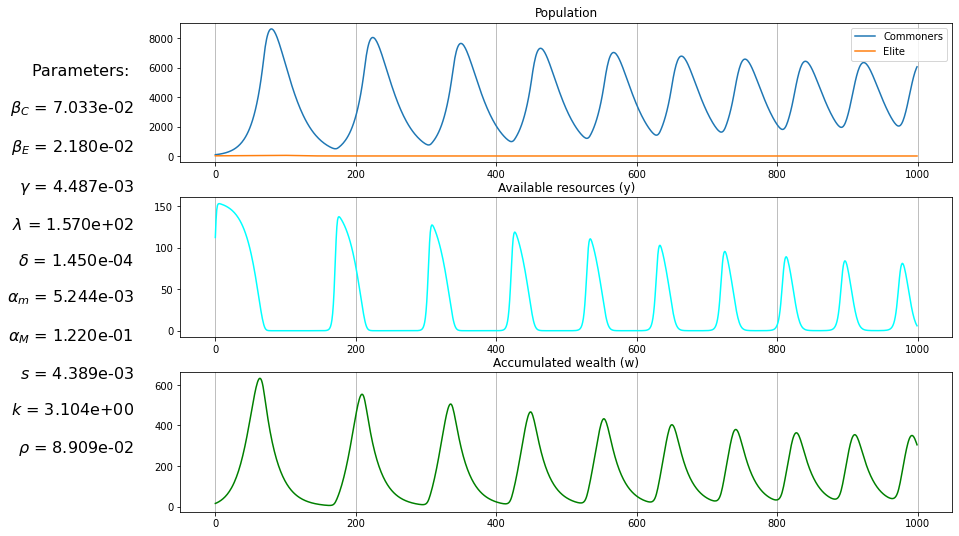

{'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 6064.218653711235, 'x_E': 0.002538477644170932, 'y': 5.970894000378703, 'w': 304.7301996226621, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0.05272870514356486, 'alpha_E': 0.0052435302734375, 'C_C': 15.518594926747271, 'C_E': 2.0182905346831298e-05, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 530.8935736704492, 'rho': 0.089085693359375}


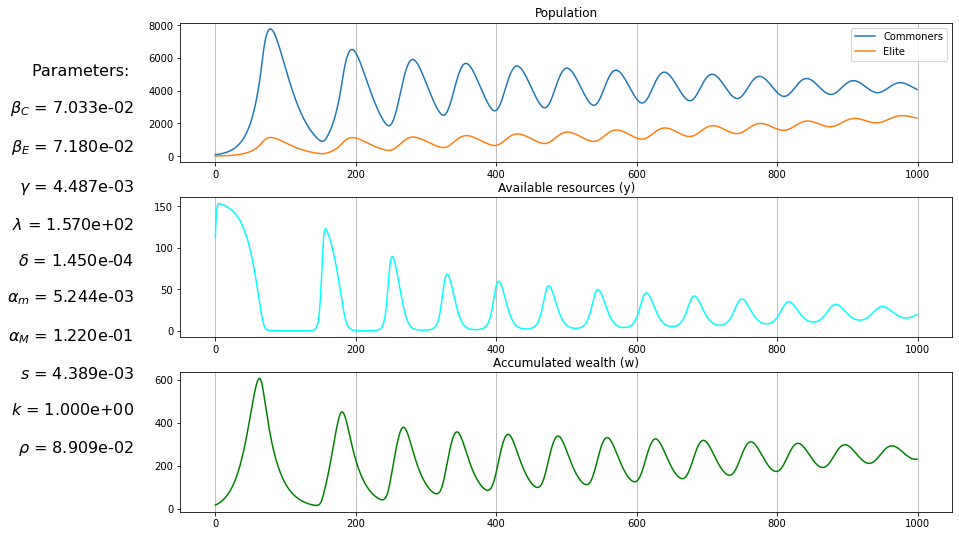

{'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.07179931640625, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 4063.727196237539, 'x_E': 2317.8921607734883, 'y': 19.88689770827971, 'w': 229.5817689695349, 'beta_C': 0.070325927734375, 'beta_E': 0.07179931640625, 'alpha_C': 0.07514662821329118, 'alpha_E': 0.07514662821329118, 'C_C': 7.192822781250661, 'C_E': 4.096618601779546, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 570.9581399973746, 'rho': 0.089085693359375}


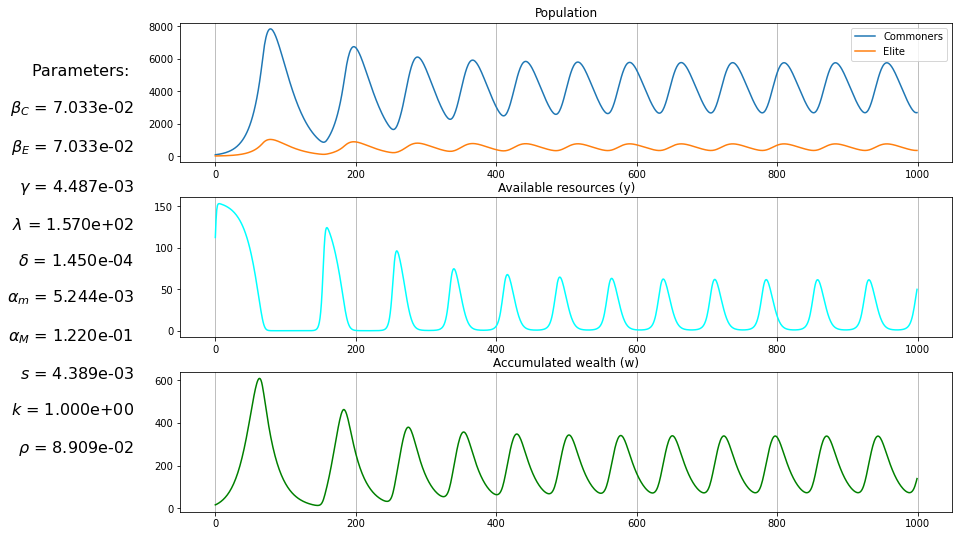

{'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 2685.306050855351, 'x_E': 353.20090968932885, 'y': 49.78647957209917, 'w': 138.86397346437622, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0.06765449047010091, 'alpha_E': 0.06765449047010091, 'C_C': 5.471660446724266, 'C_E': 0.7196928062179507, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 269.96630131996545, 'rho': 0.089085693359375}


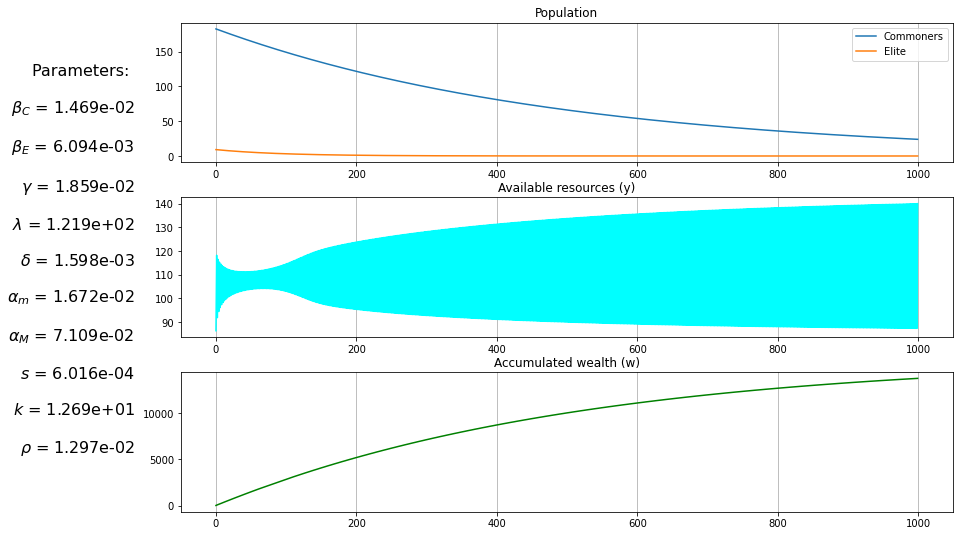

{'x_C': 182.8125, 'x_E': 9.25, 'y': 121.875, 'w': 9.0625, 'beta_C': 0.0146875, 'beta_E': 0.00609375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.01859375, 'lambda': 121.875, 'delta': 0.0015984375, 'alpha_m': 0.01671875, 'alpha_M': 0.07109375000000001, 's': 0.0006015625, 'k': 12.6875, 'w_th': 0, 'rho': 0.012968750000000001}
{'x_C': 23.930295521335392, 'x_E': 0.00021236059777569814, 'y': 140.08375162619524, 'w': 13713.909996927943, 'beta_C': 0.0146875, 'beta_E': 0.00609375, 'alpha_C': 0.01671875, 'alpha_E': 0.01671875, 'C_C': 0.014424868914535973, 'C_E': 1.6382109245854083e-06, 'gamma': 0.01859375, 'lambda': 121.875, 'delta': 0.0015984375, 'alpha_m': 0.01671875, 'alpha_M': 0.07109375000000001, 's': 0.0006015625, 'k': 12.6875, 'w_th': 0.3110130107566822, 'rho': 0.012968750000000001}


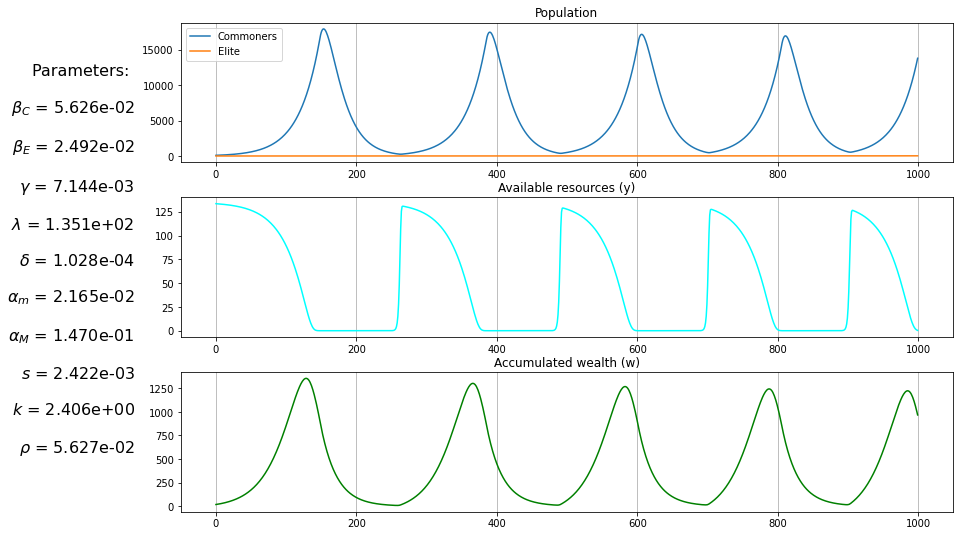

{'x_C': 104.3651123046875, 'x_E': 14.4150390625, 'y': 137.506103515625, 'w': 16.561279296875, 'beta_C': 0.05626342773437501, 'beta_E': 0.024924316406249997, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0071436767578125, 'lambda': 135.11962890625, 'delta': 0.00010278930664062501, 'alpha_m': 0.021649780273437502, 'alpha_M': 0.14701171875, 's': 0.0024223022460937503, 'k': 2.406494140625, 'w_th': 0, 'rho': 0.056273193359375}
{'x_C': 13803.13114987186, 'x_E': 37.49138268494872, 'y': 0.3555995858818609, 'w': 967.9001411688145, 'beta_C': 0.05626342773437501, 'beta_E': 0.024924316406249997, 'alpha_C': 0.021649780273437502, 'alpha_E': 0.021649780273437502, 'C_C': 32.31675482873774, 'C_E': 0.21783356964517134, 'gamma': 0.0071436767578125, 'lambda': 135.11962890625, 'delta': 0.00010278930664062501, 'alpha_m': 0.021649780273437502, 'alpha_M': 0.14701171875, 's': 0.0024223022460937503, 'k': 2.406494140625, 'w_th': 755.8202890503458, 'rho': 0.056273193359375}


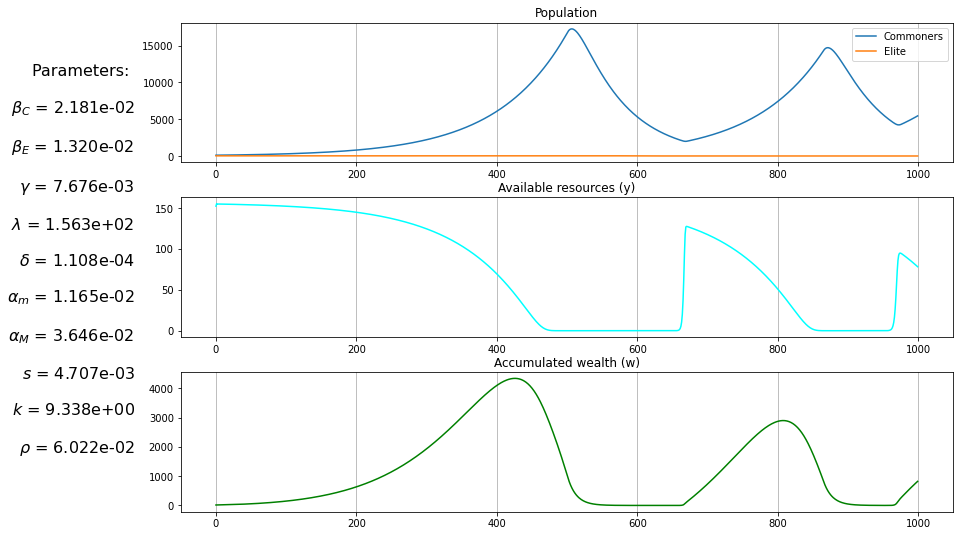

{'x_C': 106.9842529296875, 'x_E': 20.3564453125, 'y': 120.294189453125, 'w': 14.996826171875, 'beta_C': 0.021810302734375002, 'beta_E': 0.01320068359375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0076759033203125, 'lambda': 156.33544921875, 'delta': 0.00011077270507812501, 'alpha_m': 0.011652221679687502, 'alpha_M': 0.03646484375, 's': 0.004707458496093751, 'k': 9.338134765625, 'w_th': 0, 'rho': 0.06022094726562499}
{'x_C': 5451.0372866990465, 'x_E': 1.1682716880703912, 'y': 78.17359764570959, 'w': 822.0805895484064, 'beta_C': 0.021810302734375002, 'beta_E': 0.01320068359375, 'alpha_C': 0.011652221679687502, 'alpha_E': 0.011652221679687502, 'C_C': 25.402491222961423, 'C_E': 0.05127651735881608, 'gamma': 0.0076759033203125, 'lambda': 156.33544921875, 'delta': 0.00011077270507812501, 'alpha_m': 0.011652221679687502, 'alpha_M': 0.03646484375, 's': 0.004707458496093751, 'k': 9.338134765625, 'w_th': 325.6215654526218, 'rho': 0.06022094726562499}


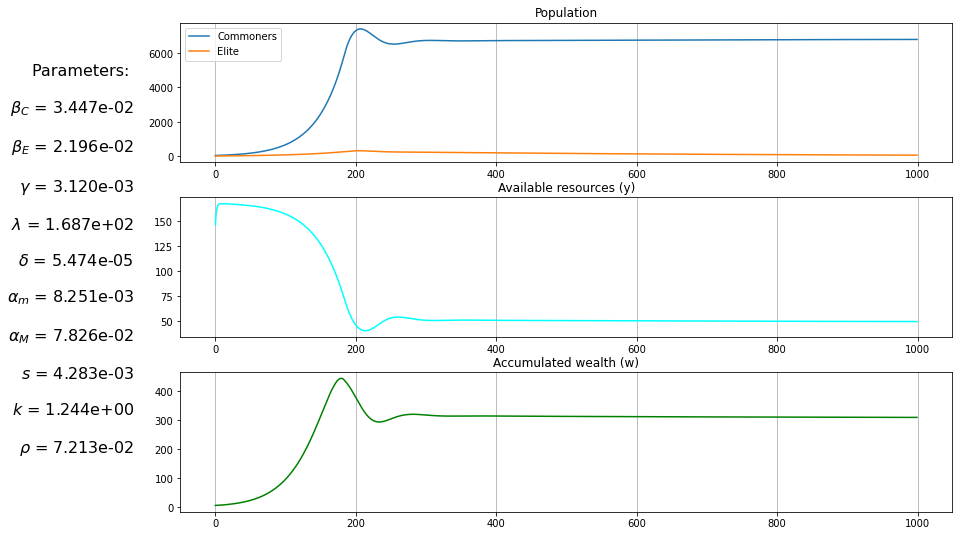

{'x_C': 49.6541748046875, 'x_E': 22.1025390625, 'y': 131.646728515625, 'w': 6.576904296875, 'beta_C': 0.034466552734375, 'beta_E': 0.021955566406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0031202392578125, 'lambda': 168.71337890625, 'delta': 5.4742431640625e-05, 'alpha_m': 0.0082513427734375, 'alpha_M': 0.07826171875, 's': 0.00428338623046875, 'k': 1.244384765625, 'w_th': 0, 'rho': 0.072132568359375}
{'x_C': 6791.039191427902, 'x_E': 70.09110906117945, 'y': 49.57552656202328, 'w': 310.4325788952909, 'beta_C': 0.034466552734375, 'beta_E': 0.021955566406249998, 'alpha_C': 0.03445709844647356, 'alpha_E': 0.023751916580304122, 'C_C': 18.2002300475411, 'C_E': 0.23417644600407167, 'gamma': 0.0031202392578125, 'lambda': 168.71337890625, 'delta': 5.4742431640625e-05, 'alpha_m': 0.0082513427734375, 'alpha_M': 0.07826171875, 's': 0.00428338623046875, 'k': 1.244384765625, 'w_th': 496.15321431214295, 'rho': 0.072132568359375}


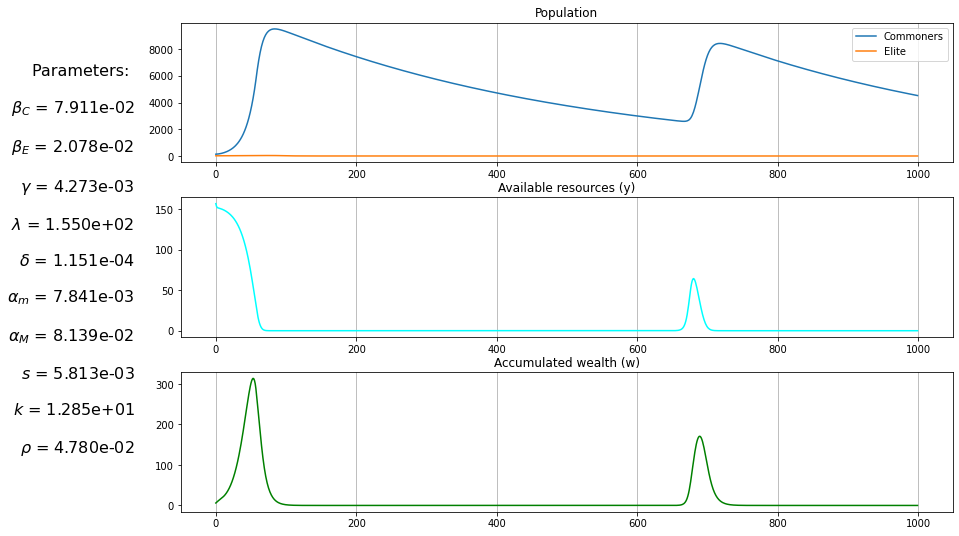

{'x_C': 131.7205810546875, 'x_E': 13.5712890625, 'y': 170.098876953125, 'w': 4.115966796875, 'beta_C': 0.079114990234375, 'beta_E': 0.02078369140625, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.004272583007812501, 'lambda': 155.04150390625, 'delta': 0.000115093994140625, 'alpha_m': 0.0078411865234375, 'alpha_M': 0.08138671875, 's': 0.005812683105468751, 'k': 12.851806640625, 'w_th': 0, 'rho': 0.047796630859374994}
{'x_C': 4522.178868477494, 'x_E': 3.209005002071795e-22, 'y': 3.27260350778125e-12, 'w': 7.531158408773966e-12, 'beta_C': 0.079114990234375, 'beta_E': 0.02078369140625, 'alpha_C': 0.08138671874999776, 'alpha_E': 0.08138671874997105, 'C_C': 8.068663303158874e-13, 'C_E': 7.815406217465088e-37, 'gamma': 0.004272583007812501, 'lambda': 155.04150390625, 'delta': 0.000115093994140625, 'alpha_m': 0.0078411865234375, 'alpha_M': 0.08138671875, 's': 0.005812683105468751, 'k': 12.851806640625, 'w_th': 216.63705463123117, 'rho': 0.047796630859374994}


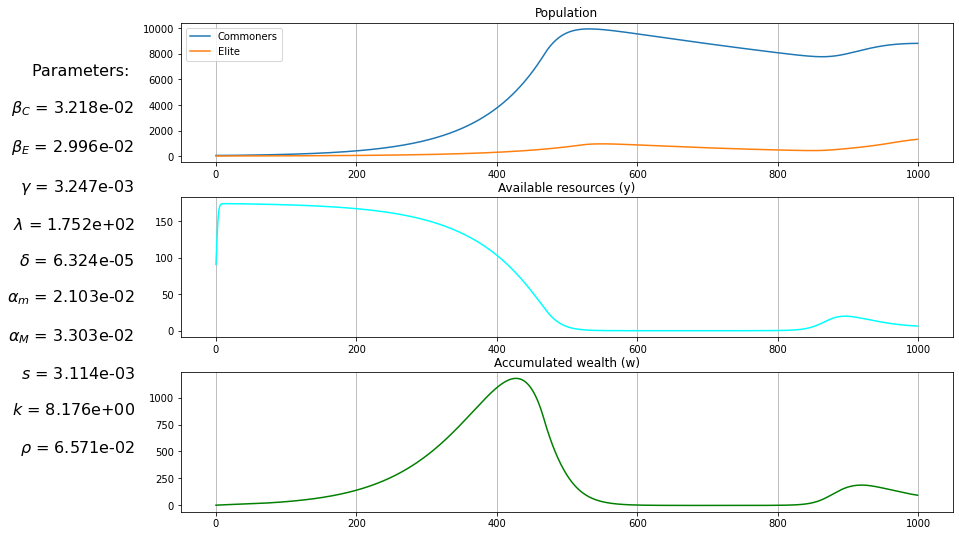

{'x_C': 48.7811279296875, 'x_E': 8.4619140625, 'y': 67.486572265625, 'w': 2.252685546875, 'beta_C': 0.032181396484375, 'beta_E': 0.029963378906249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0032471923828125, 'lambda': 175.15869140625, 'delta': 6.3238525390625e-05, 'alpha_m': 0.021034545898437503, 'alpha_M': 0.03302734375, 's': 0.00311444091796875, 'k': 8.176025390625, 'w_th': 0, 'rho': 0.065706787109375}
{'x_C': 8809.798828329218, 'x_E': 1313.0432014961307, 'y': 6.31258620657117, 'w': 94.73608669179295, 'beta_C': 0.032181396484375, 'beta_E': 0.029963378906249998, 'alpha_C': 0.032131013780226356, 'alpha_E': 0.025698927158752546, 'C_C': 2.0505558952167746, 'C_E': 2.488288072393722, 'gamma': 0.0032471923828125, 'lambda': 175.15869140625, 'delta': 6.3238525390625e-05, 'alpha_m': 0.021034545898437503, 'alpha_M': 0.03302734375, 's': 0.00311444091796875, 'k': 8.176025390625, 'w_th': 1281.2326106896255, 'rho': 0.065706787109375}


In [ ]:
wojtek_list = [
    {'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375},
    # BARDZO WAŻNE PONIŻEJ
    {'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.071799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375},
    {'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000144976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375},
    
    {'x_C': 182.8125, 'x_E': 9.25, 'y': 121.875, 'w': 9.0625, 'beta_C': 0.0146875, 'beta_E': 0.00609375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.01859375, 'lambda': 121.875, 'delta': 0.0015984375, 'alpha_m': 0.01671875, 'alpha_M': 0.07109375000000001, 's': 0.0006015625, 'k': 12.6875, 'w_th': 0, 'rho': 0.012968750000000001},
    {'x_C': 104.3651123046875, 'x_E': 14.4150390625, 'y': 137.506103515625, 'w': 16.561279296875, 'beta_C': 0.05626342773437501, 'beta_E': 0.024924316406249997, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0071436767578125, 'lambda': 135.11962890625, 'delta': 0.00010278930664062501, 'alpha_m': 0.021649780273437502, 'alpha_M': 0.14701171875, 's': 0.0024223022460937503, 'k': 2.406494140625, 'w_th': 0, 'rho': 0.056273193359375},
    {'x_C': 106.9842529296875, 'x_E': 20.3564453125, 'y': 120.294189453125, 'w': 14.996826171875, 'beta_C': 0.021810302734375002, 'beta_E': 0.01320068359375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0076759033203125, 'lambda': 156.33544921875, 'delta': 0.00011077270507812501, 'alpha_m': 0.011652221679687502, 'alpha_M': 0.03646484375, 's': 0.004707458496093751, 'k': 9.338134765625, 'w_th': 0, 'rho': 0.06022094726562499},
    {'x_C': 49.6541748046875, 'x_E': 22.1025390625, 'y': 131.646728515625, 'w': 6.576904296875, 'beta_C': 0.034466552734375, 'beta_E': 0.021955566406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0031202392578125, 'lambda': 168.71337890625, 'delta': 5.4742431640625e-05, 'alpha_m': 0.0082513427734375, 'alpha_M': 0.07826171875, 's': 0.00428338623046875, 'k': 1.244384765625, 'w_th': 0, 'rho': 0.072132568359375},
    {'x_C': 131.7205810546875, 'x_E': 13.5712890625, 'y': 170.098876953125, 'w': 4.115966796875, 'beta_C': 0.079114990234375, 'beta_E': 0.02078369140625, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.004272583007812501, 'lambda': 155.04150390625, 'delta': 0.000115093994140625, 'alpha_m': 0.0078411865234375, 'alpha_M': 0.08138671875, 's': 0.005812683105468751, 'k': 12.851806640625, 'w_th': 0, 'rho': 0.047796630859374994},
    # Poniżej ciekawy dla iterations = 1000
    {'x_C': 48.7811279296875, 'x_E': 8.4619140625, 'y': 67.486572265625, 'w': 2.252685546875, 'beta_C': 0.032181396484375, 'beta_E': 0.029963378906249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0032471923828125, 'lambda': 175.15869140625, 'delta': 6.3238525390625e-05, 'alpha_m': 0.021034545898437503, 'alpha_M': 0.03302734375, 's': 0.00311444091796875, 'k': 8.176025390625, 'w_th': 0, 'rho': 0.065706787109375},
]

for baseline_candidate in wojtek_list:
    model = HANDYModel(baseline_candidate)
    #model = NewHandyModel(baseline_cadidate)
    try:
        model.evaluate(1000, plotAfter=True)
    except: pass

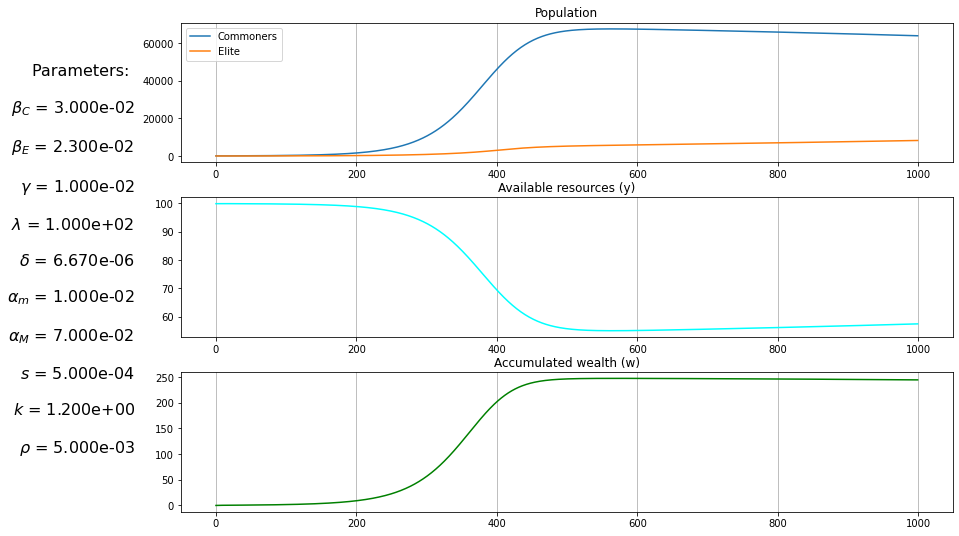

In [ ]:
initialParameters = {
    "x_C":      1e2, # Commoners population
    "x_E":      25, # Elites population
    "y":        100, # Available resources
    "w":        0, # Accumulated wealth

    "beta_C":   3e-2, # Birth rate of Commoners
    "beta_E":   2.3e-2, # Birth rate of Elites
    "gamma":    1e-2, # Regeneration factor = How fast resources regenerate
    "lambda":   100, # Nature's capacity = How many resources can exist at one time
    "delta":    6.67e-6, # Rate of depletion per worker
    "alpha_m":  1e-2, # 'Healthy' death rate
    "alpha_M":  7e-2, # 'Famine' death rate
    "s":        5e-4, # Subsistence per capita
    "k":        1.2, # Elites salary multiplier
    "rho":      5e-3, # Minimum required consumption per capita
}

model = HANDYModel(initialParameters)

try:
    for i in range(1000):
        model.update()
except:
    pass
model.plot()

## Próba implementacji wykresów z papieru

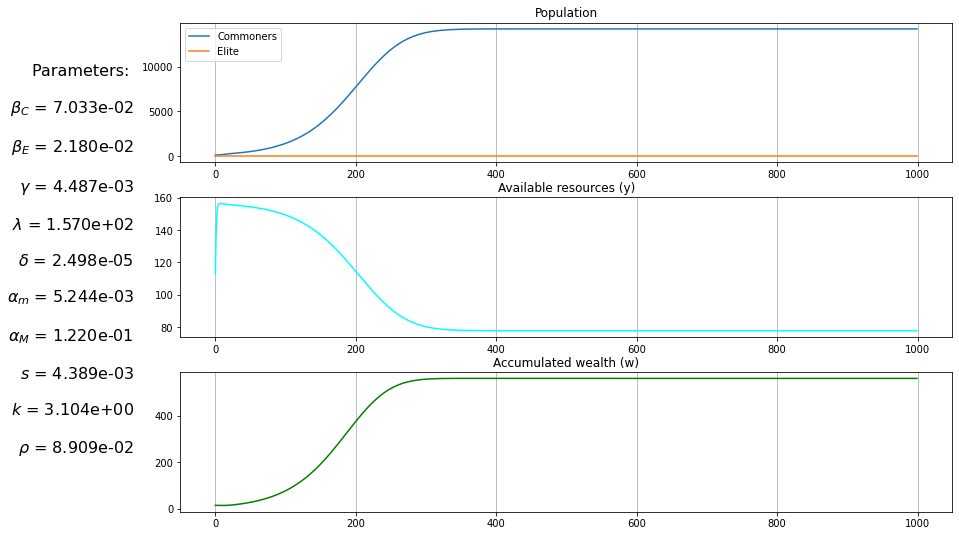

{'x_C': 81.0838623046875, 'x_E': 0, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 2.4976806640625e-05, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 14232.222408618007, 'x_E': 0.0, 'y': 77.77874721023167, 'w': 561.2124681453408, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0.07032592773437507, 'alpha_E': 0.0052435302734375, 'C_C': 27.6484365001761, 'C_E': 0.0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 2.4976806640625e-05, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 1267.8874013165691, 'rho': 0.089085693359375}


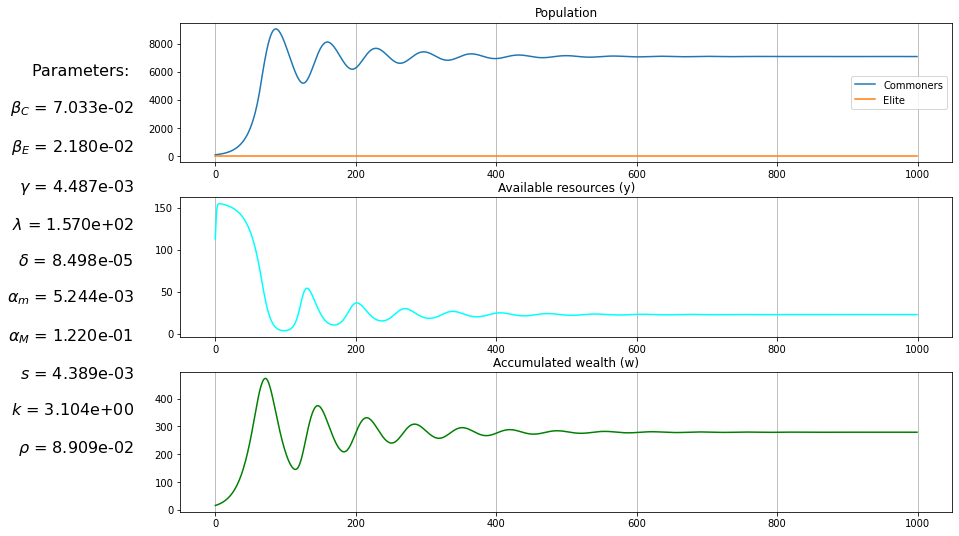

{'x_C': 81.0838623046875, 'x_E': 0, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 8.4976806640625e-05, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 7082.597970853461, 'x_E': 0.0, 'y': 22.863124312985313, 'w': 279.24971032739296, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0.0703333624102982, 'alpha_E': 0.0052435302734375, 'C_C': 13.757236392169238, 'C_E': 0.0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 8.4976806640625e-05, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 630.962842023433, 'rho': 0.089085693359375}


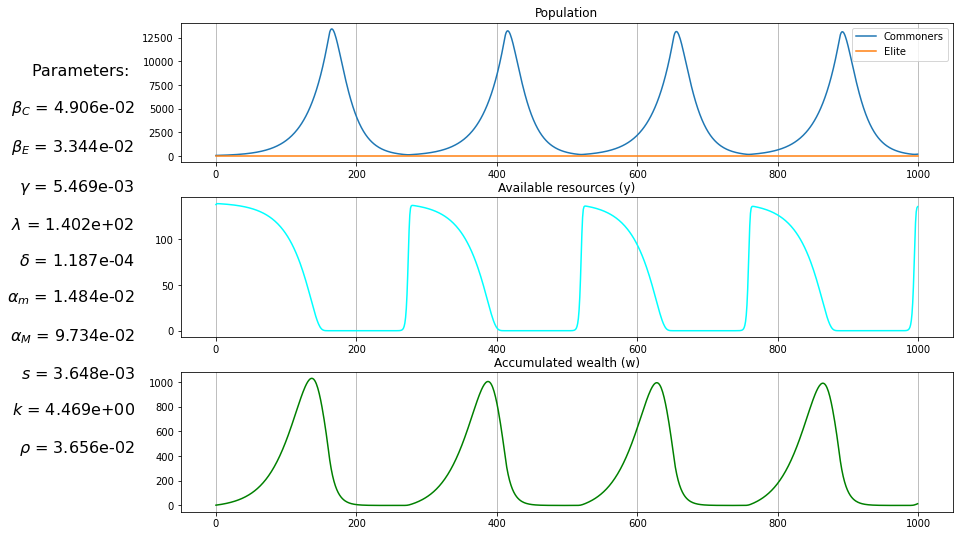

{'x_C': 55.9375, 'x_E': 0, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005}
{'x_C': 192.48905687413355, 'x_E': 0.0, 'y': 135.51573262882926, 'w': 13.941581543732934, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0.01484375, 'alpha_E': 0.01484375, 'C_C': 0.6790481157291158, 'C_E': 0.0, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 6.805021802167587, 'rho': 0.036562500000000005}


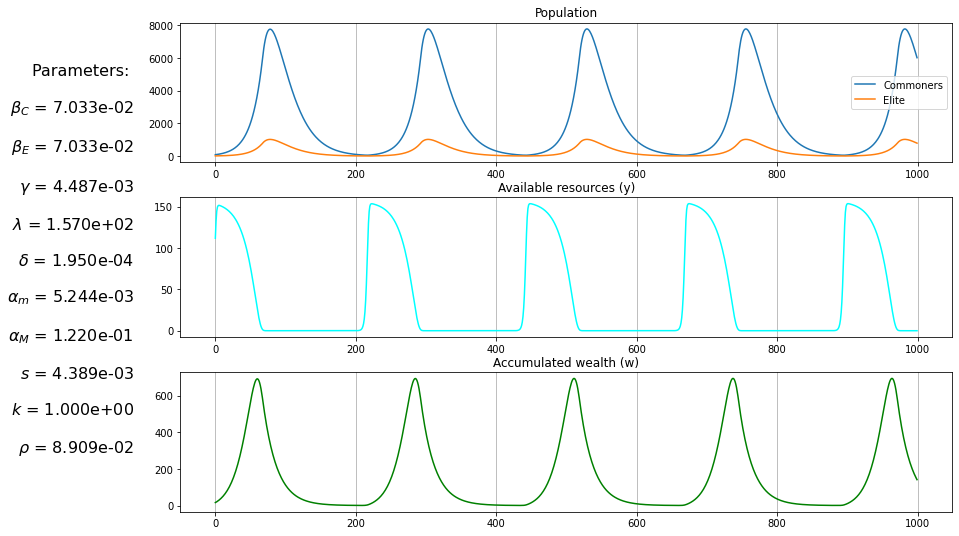

{'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000194976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375}
{'x_C': 6024.470016885954, 'x_E': 792.4043852217242, 'y': 1.2434968478518416e-15, 'w': 141.21546895475802, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0.09413186535846031, 'alpha_E': 0.09413186535846031, 'C_C': 6.466955303525447, 'C_E': 0.8506049041962488, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000194976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 622.0955505276188, 'rho': 0.089085693359375}
y_last = 4.914476172036918e-40


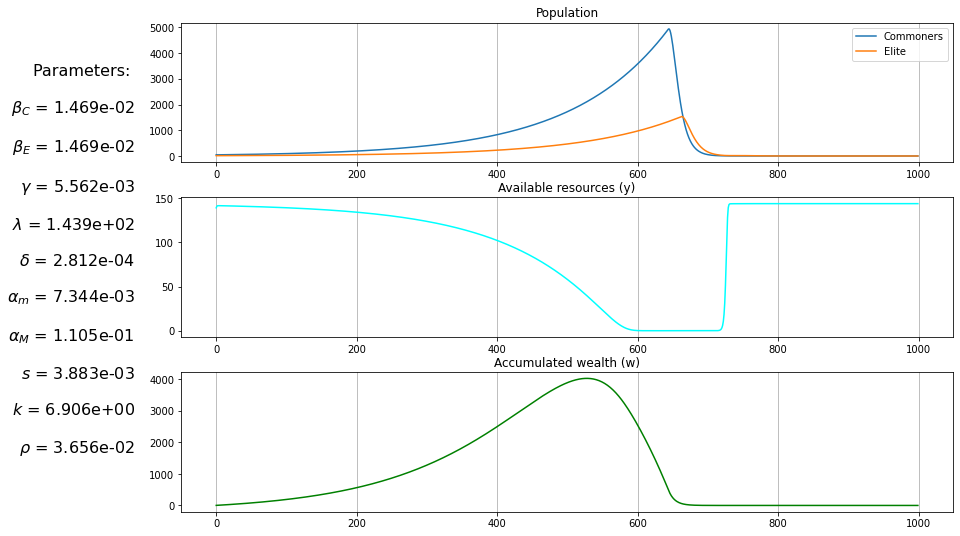

{'x_C': 52.8125, 'x_E': 12.71875, 'y': 132.65625, 'w': 0.3125, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 0, 'rho': 0.036562500000000005}
{'x_C': 1.3281209410067766e-11, 'x_E': 2.054216049743672e-08, 'y': 143.90624999999932, 'w': 4.0541790967397726e-11, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0.10965925658874244, 'alpha_E': 0.10487818612850243, 'C_C': 4.472715429683114e-16, 'C_E': 4.752627873255279e-12, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 5.701836871809535e-09, 'rho': 0.036562500000000005}


In [ ]:
lista_papierowa = [
    # Egalitarian Society: Soft Landing to Optimal Equilibrium
    {'x_C': 81.0838623046875, 'x_E': 0, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000024976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375},
    
    # Egalitarian Society: Oscillatory Approach to Equilibrium
    {'x_C': 81.0838623046875, 'x_E': 0, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.021799316406249998, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000084976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 3.103759765625, 'w_th': 0, 'rho': 0.089085693359375},
    
    # Egalitarian Society: Cycles of Prosperity and Reversible, Type-N Collapses
    {'x_C': 55.9375, 'x_E': 0, 'y': 134.53125, 'w': 1.5625, 'beta_C': 0.0490625, 'beta_E': 0.033437499999999995, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.00546875, 'lambda': 140.15625, 'delta': 0.00011875, 'alpha_m': 0.01484375, 'alpha_M': 0.09734375, 's': 0.0036484374999999998, 'k': 4.46875, 'w_th': 0, 'rho': 0.036562500000000005},


    # Egalitarian Society: Irreversible, Type-N (Full) Collapse
      # TODO Znajdź jakiś
    
    
    # Equitable Society: Soft Landing to Optimal Equilibrium

    # Equitable Society: Oscillatory Approach to Equilibrium

    # Equitable Society: Cycles of Prosperity and Reversible, Type-N Collapses
    {'x_C': 81.0838623046875, 'x_E': 10.6650390625, 'y': 85.943603515625, 'w': 14.873779296875, 'beta_C': 0.070325927734375, 'beta_E': 0.070325927734375, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0044874267578125, 'lambda': 156.99462890625, 'delta': 0.000194976806640625, 'alpha_m': 0.0052435302734375, 'alpha_M': 0.12201171875000001, 's': 0.004388854980468751, 'k': 1.0, 'w_th': 0, 'rho': 0.089085693359375},

    # Equitable Society: Irreversible, Type-N (Full) Collapse
    {'x_C': 52.8125, 'x_E': 12.71875, 'y': 132.65625, 'w': 0.3125, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00058125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 1, 'w_th': 0, 'rho': 0.036562500000000005},




    # Unequal Society: Type-L Collapse (Scarcity of Labor)
    
    # Unequal Society: Irreversible, Type-N (Full) Collapse
    {'x_C': 52.8125, 'x_E': 12.71875, 'y': 132.65625, 'w': 0.3125, 'beta_C': 0.0146875, 'beta_E': 0.0146875, 'alpha_C': 0, 'alpha_E': 0, 'C_C': 0, 'C_E': 0, 'gamma': 0.0055625, 'lambda': 143.90625, 'delta': 0.00028125, 'alpha_m': 0.00734375, 'alpha_M': 0.11046875, 's': 0.0038828125, 'k': 6.90625, 'w_th': 0, 'rho': 0.036562500000000005},

    # Unequal Society: Soft Landing to Optimal Equilibrium

    # Unequal Society: Oscillatory Approach to Equilibrium

]

for baseline_candidate in lista_papierowa:
    model = HANDYModel(baseline_candidate)
    #model = NewHandyModel(baseline_cadidate)
    try:
        model.evaluate(1000, plotAfter=True)
    except HandyError as e:
      print(str(e)) 